This notebook combines the previous data preparation steps into one single dataset containing all the information related to the song lyrics, artist type and gender, poluparity of the song. We remove songs marked as duplicates, but keeping the ones identified as covers.

In [1]:
# mount GDrive
from google.colab import drive
drive.mount('/content/drive')
#drive._mount('/content/drive')

Mounted at /content/drive


In [2]:
# load dataset
!cp -r "drive/MyDrive/WASABI_gender_experiments/WASABI_gender_experiments_definitive/dataset_10/data_lyrics_group_decades" .
!cp -r "drive/MyDrive/WASABI_gender_experiments/WASABI_gender_experiments_definitive/dataset_10/data_lyrics_person_decades" .

# load data billboard dataset
!cp /content/drive/MyDrive/WASABI_gender_experiments/WASABI_gender_experiments_definitive/data/kcmillersean-billboard-hot-100-1958-2017.zip .
!unzip kcmillersean-billboard-hot-100-1958-2017.zip

# load cover/duplicates
!cp -r "drive/MyDrive/WASABI_gender_experiments/WASABI_gender_experiments_definitive/dataset_10/final_duplicates_and_covers.json" .

# load mapping WASABI to Billboard
!cp drive/MyDrive/WASABI_gender_experiments/WASABI_gender_experiments_definitive/dataset_10/billboard_wasabi_mapping.json .

# load artists info (we need artist genre)
!cp "drive/MyDrive/WASABI_gender_experiments/WASABI_gender_experiments_definitive/data/artists_info.json.gz" .

# download genre hierarchy
!wget -O wikipedia_genres_hiearchy.json https://raw.githubusercontent.com/voltraco/genres/master/categorized-subset.json 

Archive:  kcmillersean-billboard-hot-100-1958-2017.zip
  inflating: kcmillersean-billboard-hot-100-1958-2017/Hot 100 Audio Features.xlsx  
  inflating: kcmillersean-billboard-hot-100-1958-2017/Hot Stuff.csv  
--2022-02-08 15:08:31--  https://raw.githubusercontent.com/voltraco/genres/master/categorized-subset.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15709 (15K) [text/plain]
Saving to: ‘wikipedia_genres_hiearchy.json’

wikipedia_genres_hi 100%[===================>]  15.34K  --.-KB/s    in 0.001s  

2022-02-08 15:08:31 (23.3 MB/s) - ‘wikipedia_genres_hiearchy.json’ saved [15709/15709]



In [1]:
%pylab inline
import re
import json
import pandas as pd
import glob
from datetime import datetime
from collections import defaultdict
import html

Populating the interactive namespace from numpy and matplotlib


### load data

In [2]:
# load song_lyrics
data_folders = ['data_lyrics_person_decades/', 'data_lyrics_group_decades/']

song_lyrics = []
for data_folder in data_folders:
    type_ = data_folder.split('_')[-2]
    for file in glob.glob(data_folder+'*_[!.]*.json.gz'): # skip songs with no dates
        data_chunk = pd.read_json(file, orient='records', lines=True, chunksize=5000 )
        for chunk in data_chunk:        
            chunk = chunk[['song_id', 'song_title', 'artist_id', 'artist_name',
                            'song_pubdate_combined', 'song_year_combined', 'song_decade_combined', 'other_artist_info', 'lyrics',
                           'album_genre', 'genre'
                           ]]
            song_lyrics.append(chunk)

song_lyrics = pd.concat(song_lyrics)
print('Total number of song lyrics: ', song_lyrics.shape[0])
song_lyrics.head()

Total number of song lyrics:  460339


,song_id,song_title,artist_id,artist_name,song_pubdate_combined,song_year_combined,song_decade_combined,other_artist_info,lyrics,album_genre,genre
0,5714dec325ac0d8aee3863ff,Long Live The King,56d7ef2356847be81b3e8bce,Adrian Snell,1980-01-01,1980,1980,"{'n_albums': 6, 'n_songs': 101, 'languages': {...",Six days before the Passover ceremonies began ...,,None
1,5714dec325ac0d8aee386400,The Last Supper,56d7ef2356847be81b3e8bce,Adrian Snell,1980-01-01,1980,1980,"{'n_albums': 6, 'n_songs': 101, 'languages': {...","That evening as he sat eating with the twelve,...",,None
2,5714dec325ac0d8aee386401,Gethsemane,56d7ef2356847be81b3e8bce,Adrian Snell,1980-01-01,1980,1980,"{'n_albums': 6, 'n_songs': 101, 'languages': {...","Then Jesus brought them to a garden grove, Get...",,None
3,5714dec325ac0d8aee386402,Betrayal,56d7ef2356847be81b3e8bce,Adrian Snell,1980-01-01,1980,1980,"{'n_albums': 6, 'n_songs': 101, 'languages': {...","Judas had told them, ""You will know which one ...",,None
4,5714dec325ac0d8aee386403,Son Of The World,56d7ef2356847be81b3e8bce,Adrian Snell,1980-01-01,1980,1980,"{'n_albums': 6, 'n_songs': 101, 'languages': {...","Mary, Mother of Jesus\nSon of my heart where a...",,None


In [3]:
# load the duplicated lyrics of WASABI
song_duplicates = pd.read_json('final_duplicates_and_covers.json')
song_duplicates.head()

,song_id,duplicated_of,cover_of,is_duplicated,is_cover
0,5714deec25ac0d8aee5735f8,5714deec25ac0d8aee573522,None,True,False
1,5714dec625ac0d8aee3a5ee7,5714dec625ac0d8aee3a5d8d,None,True,False
2,5714ded925ac0d8aee493bfd,5714ded925ac0d8aee493af6,None,True,False
3,5714ded925ac0d8aee493c75,5714ded925ac0d8aee493af6,None,True,False
4,5714ded925ac0d8aee493ca1,5714ded925ac0d8aee493af6,None,True,False


In [4]:
# load Billboard chart data
song_info = pd.read_excel('kcmillersean-billboard-hot-100-1958-2017/Hot 100 Audio Features.xlsx')
charts = pd.read_csv("kcmillersean-billboard-hot-100-1958-2017/Hot Stuff.csv")

# remove songs published before 1960 and after 2010
charts.loc[:, 'year'] = charts.WeekID.apply(lambda week: int(week.split("/")[-1]))
charts = charts[(charts.year>=1959)&(charts.year<=2010) ]
song_info = song_info[song_info.SongID.isin(charts.SongID.values)]

# get all the positions of songs in charts
song_positions = charts.groupby('SongID').apply(lambda rows: pd.Series({'chart_positions':rows['Week Position'].tolist(),
                                                                        'first_week_in_chart':rows['WeekID']\
                                                                            .apply(lambda d: datetime.strptime(d, "%m/%d/%Y"))\
                                                                            .sort_values().iloc[0] })).reset_index()
song_positions.loc[:, 'first_week_in_chart'] = song_positions.first_week_in_chart.apply(lambda d: d.strftime("%m/%d/%Y"))                                                      
song_info = song_info.merge(song_positions, on='SongID', how='left')

# keep columns of interest
song_info = song_info[['SongID', 'Performer', 'Song', 'chart_positions', 'first_week_in_chart']]
song_info = song_info.drop_duplicates(subset=['SongID'])
print('Number of songs in billboard: ', song_info.shape[0])
print('Number of songs in billboard (top 10): ', song_info[song_info.chart_positions.apply(lambda rks: any([rk<=10 for rk in rks]))].shape[0])

song_info.head(2)

Number of songs in billboard:  24180
Number of songs in billboard (top 10):  4348


,SongID,Performer,Song,chart_positions,first_week_in_chart
0,All I Want For Christmas Is YouMariah Carey,Mariah Carey,All I Want For Christmas Is You,[83],01/08/2000
1,Rockin' Around The Christmas TreeBrenda Lee,Brenda Lee,Rockin' Around The Christmas Tree,"[64, 89, 64, 59, 85, 84, 58, 50, 50, 26, 14, 18]",12/10/1960


In [5]:
# load the mapping
mapping_wasabi_bill = pd.read_json("billboard_wasabi_mapping.json")
print("Number of billboard songs matched: ", mapping_wasabi_bill.shape[0])

# few wasabi_ids mapped to more than 1 billboard ids
# keep them only if the song title is exactly the same
# 29 songs lost
mapping_wasabi_bill = mapping_wasabi_bill[(~mapping_wasabi_bill.song_id_w.duplicated(False))|
                                          (mapping_wasabi_bill.title_b==mapping_wasabi_bill.title_w)].drop_duplicates(subset=['song_id_w'])
print("Number of billboard songs matched with unique wasabi songs: ", mapping_wasabi_bill.shape[0])
print("Wasabi ids are unique?: ", not mapping_wasabi_bill.song_id_w.duplicated().any())
print("Billboard ids are unique?: ", not mapping_wasabi_bill.song_id_b.duplicated().any())
mapping_wasabi_bill.head()

Number of billboard songs matched:  11024
Number of billboard songs matched with unique wasabi songs:  10995
Wasabi ids are unique?:  True
Billboard ids are unique?:  True


,song_id_b,title_b,artist_name_b,week,WeekID,songs_wasabi,songs_wasabi_dedup,song_id_w,title_w,artist_name_w,song_year_w
0,"""Joy"" Pt. IIsaac Hayes","""joy"" pt. i",isaac hayes,125366400000,12/22/1973,"[[5714ded425ac0d8aee451d3c, joy, isaac hayes, ...","[5714ded425ac0d8aee451d3c, joy, isaac hayes, 1...",5714ded425ac0d8aee451d3c,joy,isaac hayes,1973
1,'03 Bonnie & ClydeJay-Z Featuring Beyonce Knowles,'03 bonnie and clyde,jay-z featuring beyonce knowles,1035590400000,10/26/2002,"[[5714ded425ac0d8aee459dfe, '03 bonnie and cly...","[5714ded425ac0d8aee459dfe, '03 bonnie and clyd...",5714ded425ac0d8aee459dfe,'03 bonnie and clyde,jay-z,2002
2,'65 Love AffairPaul Davis,'65 love affair,paul davis,383616000000,2/27/1982,"[[5714dedf25ac0d8aee4d80c5, '65 love affair, p...","[5714dedf25ac0d8aee4d80c5, '65 love affair, pa...",5714dedf25ac0d8aee4d80c5,'65 love affair,paul davis,1981
3,'Til My Baby Comes HomeLuther Vandross,'til my baby comes home,luther vandross,479779200000,3/16/1985,"[[5714deda25ac0d8aee49857a, 'til my baby comes...","[5714deda25ac0d8aee49857a, 'til my baby comes ...",5714deda25ac0d8aee49857a,'til my baby comes home,luther vandross,1985
4,'Til Summer Comes AroundKeith Urban,'til summer comes around,keith urban,1264809600000,1/30/2010,"[[5714ded725ac0d8aee474da1, 'til summer comes ...","[5714ded725ac0d8aee474da1, 'til summer comes a...",5714ded725ac0d8aee474da1,'til summer comes around,keith urban,2009


### Assign genre

In [6]:
# load artist info with genre
all_artist_id = set(song_lyrics.artist_id.unique())

artists_info = pd.read_json('artists_info.json.gz',
                            orient='records',
                            lines=True)
artists_info = artists_info[artists_info.artist_id.isin(all_artist_id)][['artist_id', 'dbp_genre', 'n_songs']]

# load genre hierarchy
genres_category = json.load(open('wikipedia_genres_hiearchy.json'))

# this function remove the final string " music" from genre name (in that way, "Rock music" becomes "Rock")
clean_genre_name = lambda g: re.sub(" music$", "", g, flags=re.I)

genres_category = {g:[clean_genre_name(i) for i in gs] for g, gs in genres_category.items()}


In [7]:
# manually inspected all genres in Wasabi not in genres_category (occurring in more than 10 artists)
# Searching in this page https://en.wikipedia.org/wiki/List_of_music_genres_and_styles
other_genres = {
    # from dbp_genre artist
    'Gospel music':['R&B and soul'],
    'Dance music':None, # electronic ???
    'Contemporary Christian music':None,
    'Acoustic music':None,
    'Americana (music)':['Folk', 'Country'],
    'Independent music':None,
    'World music':None,
    'Dream pop':['Rock'],
    'Electronic dance music	':None,
    'Roots rock':['Rock'],
    'Classical music':None,
    'Shoegazing':None,
    'Melodic hardcore':['Rock'],
    'Electro (music)':['Electronic'],
    'Contemporary worship music':None,
    'Instrumental rock':['Rock'],
    'Funk rock':['Rock'],
    'Heartland rock':['Rock'],
    'Film score':None,
    'American folk music':['Folk'],
    'Jam band':None,
    'Rapping':None, # maybe HipHop RnB?
    'Surf music':None,
    'Intelligent dance music':['Electronic'],
    'Comedy rock':['Rock'],
    'Proto-punk':None,
    'Symphonic rock':['Rock'],
    'Noise pop':['Rock'],
    'Doo-wop':['Blues', 'R&B and soul'],
    'Low fidelity':None,
    'Music of the Philippines':None,
    'Album-oriented rock':None,
    'Big band':None,
    'Urban contemporary':None,
    'Christian music':None,
    'Reggae rock':['Rock', 'Caribbean and Caribbean-influenced'],
    'Musical theatre':None,
    'Spoken word':None,
    'Dub (music)':['Electronic', 'Caribbean and Caribbean-influenced'],
    'Urban contemporary gospel':None,
    'Pub rock (United Kingdom)':['Rock'],
    'Popular music':None,
    'Roots reggae':['Caribbean and Caribbean-influenced'],
    'Honky-tonk':['Country'],
    'Folk music of Ireland':['Folk'],
    'Adult album alternative':['Pop'],
    'Glitch (music)':['Electronic'],
    'Psychedelic soul':['R&B and soul'],
    'Crossover (music)':None,
    # from album genre (occurring more than 100 times)
    'R&B':['R&B and soul'],
    'Christmas':None,
    'Vocal':None,
    "Rock 'N' Roll":['Rock'],
    'Classic Pop':['Pop'],
    'Dance':None,
    'Irish Folk':['Folk'],
    'EBM':['Electronic'],
    'Acoustic':None,
    'Adult Alternative':['Pop'],
    'Indie':None, # it is too general
    'Christian':None,
    'Worship':None,
    'Midwest Rap':['Hip hop'],
    'Soundtrack':None,
    'J-Rock':['Rock'],
    'Roots':None,
    'Classic Rock':['Rock'],
    'World Music':None,
    'New Age':['Electronic', 'Easy listening'],
    "Children's Music":None,
    'Piano Rock':['Rock'],
    'Nerdcore Hip Hop':['Hip hop'],
    'Progressive Death Metal':['Rock'],
    'Gothic':['Rock'],
    'Spoken Word':None,
    'Classical':None,
    'Celtic Rock':['Rock', 'Folk'],
    'Shoegazing':['Rock'],
    'MPB':None,
    'Psych Folk':['Folk'],
    'Gregorian Chant':None,
    'Extreme Metal':['Rock'],



}

other_genres = {clean_genre_name(g):gs for g, gs in other_genres.items()}
other_genres_keys = set(other_genres.keys())
other_genres_lower = {g.lower():gs for g, gs in other_genres.items()}
other_genres_lower_keys = set(other_genres_lower.keys())

In [8]:
def assign_genres(genres_list, to_lower=False):
    '''
    Use the taxonomy of Wikipedia to assign genres to each song. It returns a list of genres.
    For example, if the genres of input are ['Contemporary R&B', 'Hip hop music'] this function returns ['R&B and soul', 'Hip hop', 'Blues'].
    This is because 'Contemporary R&B' is a subgenre of both 'R&B and soul' and 'Blues'.
    '''
    if type(genres_list) is not list or len(genres_list)==0:
        return None

    # remove " music"
    genres_list = [clean_genre_name(i) if not to_lower else clean_genre_name(i).lower() for i in genres_list]
    genres_list_collapsed = []
    for g in genres_list:
        for G,SUB_GS in genres_category.items():
            G_ = G if not to_lower else G.lower()
            SUB_GS = SUB_GS if not to_lower else [genre.lower() for genre in SUB_GS]
            if g==G_:
                genres_list_collapsed.append(G)
            elif g in SUB_GS:
                genres_list_collapsed.append(G) 
            elif not to_lower and g in other_genres_keys:
                g_matched = other_genres[g]
                if g_matched is not None:
                    genres_list_collapsed.extend(g_matched)
            elif to_lower and g in other_genres_lower_keys:
                g_matched = other_genres_lower[g]
                if g_matched is not None:
                    genres_list_collapsed.extend(g_matched)

    if len(genres_list_collapsed)>0:
        genres_list_collapsed = list(set(genres_list_collapsed))
    else:
        genres_list_collapsed = None

    return genres_list_collapsed


def assign_genres_priority(song_genres, album_genre, artist_genres):
    '''
    Assigns the genres of the song to the song. If no song genre, assigns the genre of the album. If no album genre, the genres of the artist is assigned.
    '''

    if type(song_genres) is list and len(song_genres)>0:
        genres_list_collapsed = assign_genres(song_genres, to_lower=True)
        from_ = 'song'
    elif type(album_genre) is str and album_genre!='':
        genres_list_collapsed = assign_genres([album_genre], to_lower=True)
        from_ = 'album'
    elif type(artist_genres) is list and len(artist_genres)>0:
        genres_list_collapsed = assign_genres(artist_genres, to_lower=True)
        from_ = 'artist'
    else:
        genres_list_collapsed = None
        from_ = None

    return genres_list_collapsed, from_

### Fractions of Billboard songs mapped across time

#### Billboard

In [9]:
charts = charts[charts.SongID.isin(song_info.SongID)]
charts.loc[:, 'week'] = charts.WeekID.apply(lambda d: datetime.strptime(d, "%m/%d/%Y").replace(day=1))

n_wasabi_in_charts = charts.groupby("week").apply(lambda rows: rows.SongID.isin(mapping_wasabi_bill.song_id_b).mean())

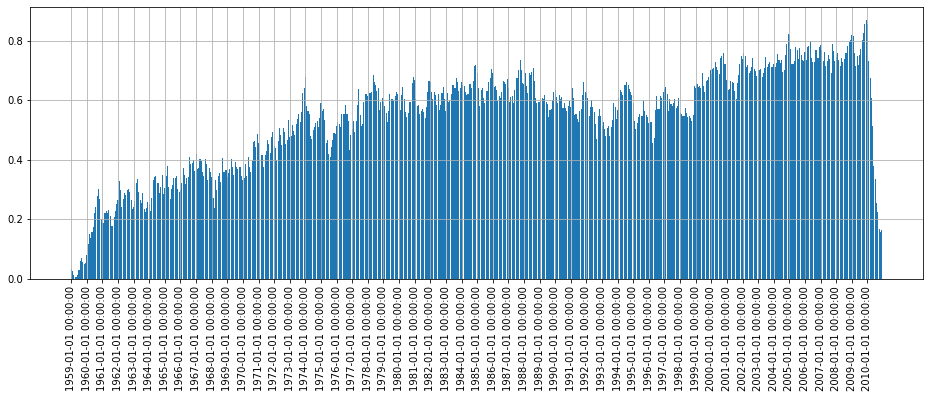

In [10]:
plt.figure(figsize=(16,5))
plt.bar(range(len(n_wasabi_in_charts.index)), n_wasabi_in_charts.values)

plt.xticks(range(0, len(n_wasabi_in_charts.index), 12), n_wasabi_in_charts.index[::12], rotation=90);
plt.grid()

#### Billboard top 10

In [15]:
charts_top10 = charts[(charts.SongID.isin(song_info.SongID))&
                    (charts['Peak Position']<=10)]
charts_top10.loc[:, 'week'] = charts_top10.WeekID.apply(lambda d: datetime.strptime(d, "%m/%d/%Y").replace(day=1))

n_wasabi_in_charts_top10 = charts_top10.groupby("week").apply(lambda rows: rows.SongID.isin(mapping_wasabi_bill.song_id_b).mean())

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


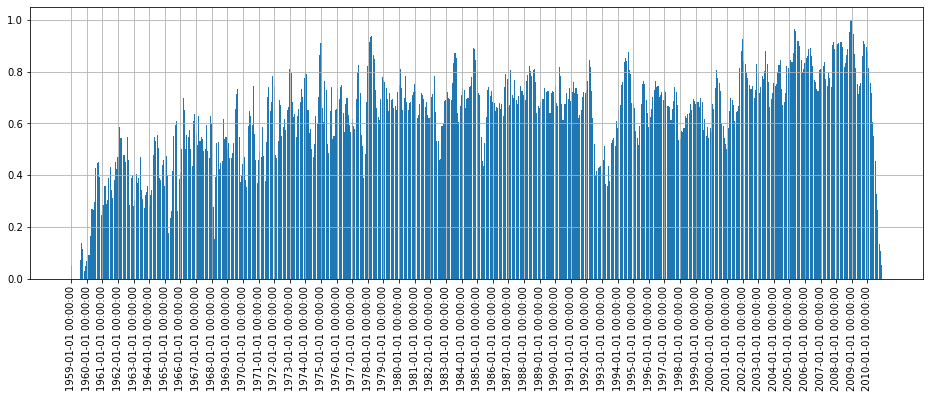

In [16]:
plt.figure(figsize=(16,5))
plt.bar(range(len(n_wasabi_in_charts_top10.index)), n_wasabi_in_charts_top10.values)

plt.xticks(range(0, len(n_wasabi_in_charts_top10.index), 12), n_wasabi_in_charts_top10.index[::12], rotation=90);
plt.grid()

### Merge all

1. Remove duplicate songs from song_lyrics and Add info on cover songs
2. Add popularity fields through the mapping table
3. Add genres

In [17]:
# 1. Remove duplicate songs from song_lyrics and Add info on cover songs
song_lyrics = song_lyrics.merge(song_duplicates, on='song_id', how='left')

print("Number of duplicate songs: ", (song_lyrics.is_duplicated==True).sum())

# remove duplicates
song_lyrics = song_lyrics[song_lyrics.is_duplicated!=True]
song_lyrics = song_lyrics.drop(columns=['is_duplicated', 'duplicated_of']).reset_index(drop=True)

print("Number of remaining lyrics after duplicates removal: ", song_lyrics.shape[0])
song_lyrics.head()

Number of duplicate songs:  82531
Number of remaining lyrics after duplicates removal:  377808


,song_id,song_title,artist_id,artist_name,song_pubdate_combined,song_year_combined,song_decade_combined,other_artist_info,lyrics,album_genre,genre,cover_of,is_cover
0,5714dec325ac0d8aee3863ff,Long Live The King,56d7ef2356847be81b3e8bce,Adrian Snell,1980-01-01,1980,1980,"{'n_albums': 6, 'n_songs': 101, 'languages': {...",Six days before the Passover ceremonies began ...,,None,NaN,NaN
1,5714dec325ac0d8aee386400,The Last Supper,56d7ef2356847be81b3e8bce,Adrian Snell,1980-01-01,1980,1980,"{'n_albums': 6, 'n_songs': 101, 'languages': {...","That evening as he sat eating with the twelve,...",,None,NaN,NaN
2,5714dec325ac0d8aee386401,Gethsemane,56d7ef2356847be81b3e8bce,Adrian Snell,1980-01-01,1980,1980,"{'n_albums': 6, 'n_songs': 101, 'languages': {...","Then Jesus brought them to a garden grove, Get...",,None,NaN,NaN
3,5714dec325ac0d8aee386402,Betrayal,56d7ef2356847be81b3e8bce,Adrian Snell,1980-01-01,1980,1980,"{'n_albums': 6, 'n_songs': 101, 'languages': {...","Judas had told them, ""You will know which one ...",,None,NaN,NaN
4,5714dec325ac0d8aee386403,Son Of The World,56d7ef2356847be81b3e8bce,Adrian Snell,1980-01-01,1980,1980,"{'n_albums': 6, 'n_songs': 101, 'languages': {...","Mary, Mother of Jesus\nSon of my heart where a...",,None,NaN,NaN


In [18]:
# 2. Add popularity fields through the mapping table

# add mapping to billboard ids
song_lyrics = song_lyrics.merge(mapping_wasabi_bill[['song_id_b', 'song_id_w']].rename(columns={'song_id_w':'song_id',
                                                                                                'song_id_b':'SongID'}),
                                on='song_id', how='left')

# now merge popularity info
song_lyrics = song_lyrics.merge(song_info[['SongID', 'chart_positions', 'first_week_in_chart']], on='SongID', how='left')
song_lyrics.head()


,song_id,song_title,artist_id,artist_name,song_pubdate_combined,song_year_combined,song_decade_combined,other_artist_info,lyrics,album_genre,genre,cover_of,is_cover,SongID,chart_positions,first_week_in_chart
0,5714dec325ac0d8aee3863ff,Long Live The King,56d7ef2356847be81b3e8bce,Adrian Snell,1980-01-01,1980,1980,"{'n_albums': 6, 'n_songs': 101, 'languages': {...",Six days before the Passover ceremonies began ...,,None,NaN,NaN,NaN,NaN,NaN
1,5714dec325ac0d8aee386400,The Last Supper,56d7ef2356847be81b3e8bce,Adrian Snell,1980-01-01,1980,1980,"{'n_albums': 6, 'n_songs': 101, 'languages': {...","That evening as he sat eating with the twelve,...",,None,NaN,NaN,NaN,NaN,NaN
2,5714dec325ac0d8aee386401,Gethsemane,56d7ef2356847be81b3e8bce,Adrian Snell,1980-01-01,1980,1980,"{'n_albums': 6, 'n_songs': 101, 'languages': {...","Then Jesus brought them to a garden grove, Get...",,None,NaN,NaN,NaN,NaN,NaN
3,5714dec325ac0d8aee386402,Betrayal,56d7ef2356847be81b3e8bce,Adrian Snell,1980-01-01,1980,1980,"{'n_albums': 6, 'n_songs': 101, 'languages': {...","Judas had told them, ""You will know which one ...",,None,NaN,NaN,NaN,NaN,NaN
4,5714dec325ac0d8aee386403,Son Of The World,56d7ef2356847be81b3e8bce,Adrian Snell,1980-01-01,1980,1980,"{'n_albums': 6, 'n_songs': 101, 'languages': {...","Mary, Mother of Jesus\nSon of my heart where a...",,None,NaN,NaN,NaN,NaN,NaN


In [19]:
# final adjustments
song_lyrics.loc[:, 'is_cover'] = song_lyrics.is_cover.fillna(False)
song_lyrics.loc[:, 'is_billboard'] = ~song_lyrics.chart_positions.isna()

song_lyrics.head()

,song_id,song_title,artist_id,artist_name,song_pubdate_combined,song_year_combined,song_decade_combined,other_artist_info,lyrics,album_genre,genre,cover_of,is_cover,SongID,chart_positions,first_week_in_chart,is_billboard
0,5714dec325ac0d8aee3863ff,Long Live The King,56d7ef2356847be81b3e8bce,Adrian Snell,1980-01-01,1980,1980,"{'n_albums': 6, 'n_songs': 101, 'languages': {...",Six days before the Passover ceremonies began ...,,None,NaN,False,NaN,NaN,NaN,False
1,5714dec325ac0d8aee386400,The Last Supper,56d7ef2356847be81b3e8bce,Adrian Snell,1980-01-01,1980,1980,"{'n_albums': 6, 'n_songs': 101, 'languages': {...","That evening as he sat eating with the twelve,...",,None,NaN,False,NaN,NaN,NaN,False
2,5714dec325ac0d8aee386401,Gethsemane,56d7ef2356847be81b3e8bce,Adrian Snell,1980-01-01,1980,1980,"{'n_albums': 6, 'n_songs': 101, 'languages': {...","Then Jesus brought them to a garden grove, Get...",,None,NaN,False,NaN,NaN,NaN,False
3,5714dec325ac0d8aee386402,Betrayal,56d7ef2356847be81b3e8bce,Adrian Snell,1980-01-01,1980,1980,"{'n_albums': 6, 'n_songs': 101, 'languages': {...","Judas had told them, ""You will know which one ...",,None,NaN,False,NaN,NaN,NaN,False
4,5714dec325ac0d8aee386403,Son Of The World,56d7ef2356847be81b3e8bce,Adrian Snell,1980-01-01,1980,1980,"{'n_albums': 6, 'n_songs': 101, 'languages': {...","Mary, Mother of Jesus\nSon of my heart where a...",,None,NaN,False,NaN,NaN,NaN,False


In [20]:
# add genres of artist
song_lyrics = song_lyrics.merge(artists_info.drop(columns=['n_songs']), on='artist_id',
                                how='left')

# combine all genres info into one single field
song_lyrics.loc[:, 'genre_combined_reduced'], song_lyrics.loc[:, 'genre_combined_reduced_from'] = zip(*song_lyrics.apply(lambda row: 
                                                                 assign_genres_priority(row.genre, 
                                                                                        html.unescape(row.album_genre), 
                                                                                        row.dbp_genre), 
                                                                 axis=1))

# fraction of lyrics with missing genre
song_lyrics.genre_combined_reduced.isna().value_counts(1)

False    0.876969
True     0.123031
Name: genre_combined_reduced, dtype: float64

In [21]:
# from where the info was taken
song_lyrics.genre_combined_reduced_from.fillna("No info").value_counts(1)

album      0.630151
artist     0.232216
No info    0.087375
song       0.050258
Name: genre_combined_reduced_from, dtype: float64

In [22]:
# count number of songs for each genre (their fraction doesn's sum at 1 because songs can have more than 1 genre)
all_genres_count = defaultdict(int)

n_songs_with_genre = song_lyrics.genre_combined_reduced.dropna().shape[0]
for genres in song_lyrics.genre_combined_reduced.dropna():
    for genre in genres:
        all_genres_count[genre] += 1

all_genres_count = pd.DataFrame.from_dict(all_genres_count, orient='index')
all_genres_count.columns = ['n_songs']
all_genres_count.index.name = 'genre'

all_genres_count.loc[:, 'frac_songs'] = all_genres_count.n_songs / n_songs_with_genre
all_genres_count = all_genres_count.sort_values('n_songs', ascending=False)
all_genres_count.head()

,n_songs,frac_songs
genre,,
Rock,157202,0.474463
Pop,67057,0.202390
Country,50055,0.151075
Hip hop,33400,0.100807
R&B and soul,32693,0.098673


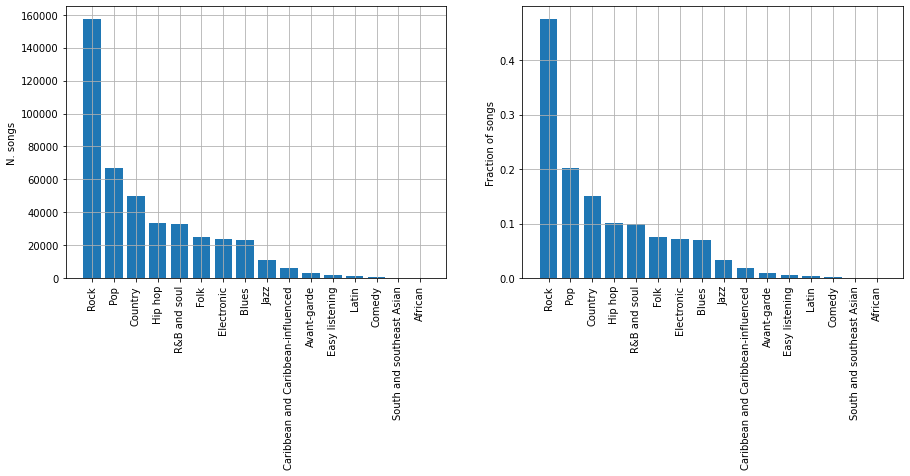

In [23]:
# show distribution of genres
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.bar(range(len(all_genres_count)), all_genres_count.n_songs)
plt.xticks(range(all_genres_count.shape[0]), all_genres_count.index, rotation=90);
plt.ylabel('N. songs')
plt.grid()

plt.subplot(1,2,2)
plt.bar(range(len(all_genres_count)), all_genres_count.frac_songs)
plt.xticks(range(all_genres_count.shape[0]), all_genres_count.index, rotation=90);
plt.ylabel('Fraction of songs')
plt.grid();

In [24]:
song_lyrics.shape[0]

377808

In [ ]:
# save the file
song_lyrics.to_json("lyrics_dataset.json.gz", orient='records', lines=True, compression='gzip')

In [ ]:
!cp "lyrics_dataset.json.gz" drive/MyDrive/WASABI_gender_experiments/WASABI_gender_experiments_definitive/dataset_10/